In [ ]:
!pip install cirq --quiet

import cirq
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.1 MB/s eta 0:00:00


In [ ]:
num_qubits = 7 #logical qubits

wlist = [
    [0, 6, 0.9676], [1, 5, 0.9575], [2, 4, 0.9746], [1, 6, 0.9974],
    [2, 5, 1.0208], [3, 4, 1.0625], [1, 0, 0.9986], [2, 6, 0.9778],
    [3, 5, 0.9694], [2, 0, 0.9474], [3, 6, 1.0100], [4, 5, 0.9612],
    [2, 1, 0.9693], [3, 0, 0.9972], [4, 6, 0.9999], [3, 1, 1.0383],
    [4, 0, 0.9960], [5, 6, 0.9663], [3, 2, 0.9808], [4, 1, 1.0240],
    [5, 0, 0.9382]
]

ws = [
    -0.4273, -2.1533, -0.3372, -0.7180,
    -1.0090, -0.6296, -1.1775
]

# Example parameters for p=2
theta = [
    0.1588, 0.2473, 2.5624, -0.0291
]

In [ ]:
def baseline_qaoa_circuit(theta, measure=True):
    qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on_each(*qubits))

    j = 0
    while j < len(theta):
        gamma = theta[j]
        for w in wlist:
            q0, q1, weight = w
            circuit.append(cirq.CNOT(qubits[q0], qubits[q1]))
            circuit.append(cirq.rz(2.0 * gamma * weight).on(qubits[q1]))
            circuit.append(cirq.CNOT(qubits[q0], qubits[q1]))
        for i in range(num_qubits):
            circuit.append(cirq.rz(2.0 * gamma * ws[i]).on(qubits[i]))

        j += 1
        beta = theta[j]
        for i in range(num_qubits):
            circuit.append(cirq.rx(-2.0 * beta).on(qubits[i]))

        j += 1

    if measure:
        circuit.append(cirq.measure(*qubits, key='result'))

    return circuit, qubits

In [ ]:
circuit, qubits = baseline_qaoa_circuit(theta)

print(circuit)

NameError: name 'cirq' is not defined

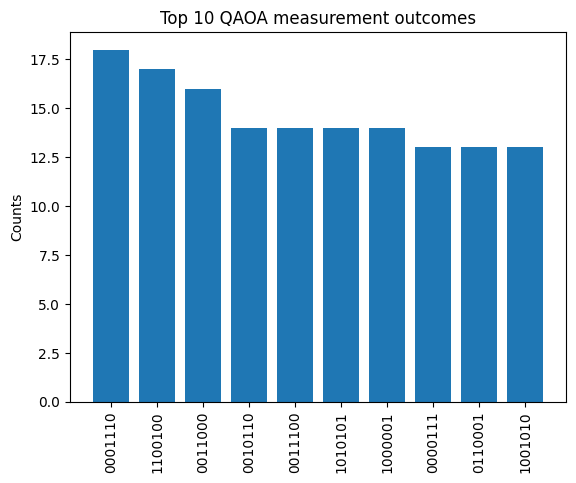

In [ ]:
import pandas as pd

# Convert histogram to a sorted DataFrame
df = pd.DataFrame({
    'bitstring': bitstrings,
    'counts': counts
})

df_sorted = df.sort_values(by='counts', ascending=False).head(10)  # top 10

plt.bar(df_sorted['bitstring'], df_sorted['counts'])
plt.xticks(rotation='vertical', fontsize=10)
plt.ylabel("Counts")
plt.title("Top 10 QAOA measurement outcomes")
plt.show()

In [ ]:
circuit_no_measure, qubits = baseline_qaoa_circuit(theta, measure=False)

# Noise model: 1% depolarizing noise after every moment
noise_model = cirq.ConstantQubitNoiseModel(cirq.depolarize(p=0.01))

# Simulators
ideal_simulator = cirq.Simulator()
noisy_simulator = cirq.DensityMatrixSimulator(noise=noise_model)

def compute_fidelity(circuit, qubits):
    # Run ideal simulation (state vector)
    ideal_result = ideal_simulator.simulate(circuit)
    ideal_state = ideal_result.final_state_vector

    # Run noisy simulation (density matrix)
    noisy_result = noisy_simulator.simulate(circuit)
    noisy_dm = noisy_result.final_density_matrix

    # Fidelity = <psi|rho|psi>
    fidelity = np.real(np.dot(ideal_state.conj().T, noisy_dm @ ideal_state))
    return fidelity

# Compute fidelity
fidelity = compute_fidelity(circuit_no_measure, qubits)

print(f"Fidelity between ideal and noisy states: {fidelity:.4f}")

Fidelity between ideal and noisy states: 0.0740


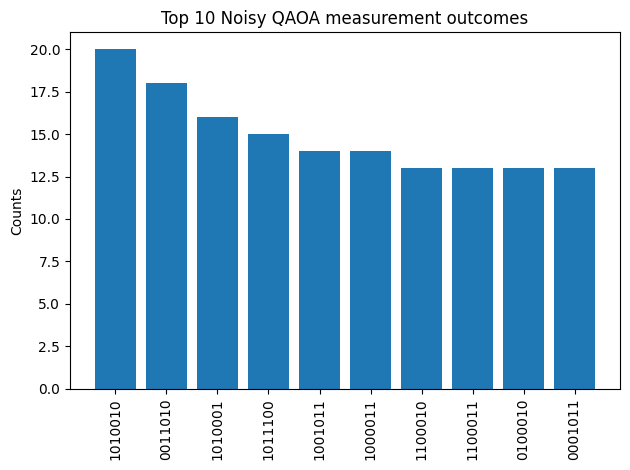

In [ ]:
noisy_result = noisy_simulator.run(circuit, repetitions=1000)
hist = noisy_result.histogram(key='result')

bitstrings = [format(k, f'0{num_qubits}b') for k in hist.keys()]
counts = list(hist.values())

df = pd.DataFrame({'bitstring': bitstrings, 'counts': counts})
df_sorted = df.sort_values(by='counts', ascending=False).head(10)  # top 10

plt.bar(df_sorted['bitstring'], df_sorted['counts'])
plt.xticks(rotation='vertical', fontsize=10)
plt.ylabel("Counts")
plt.title("Top 10 Noisy QAOA measurement outcomes")
plt.tight_layout()
plt.show()